# Difference in Differences

## *Workshop 07*  [![Open In Colab](https://github.com/oballinger/QM2/blob/main/colab-badge.png?raw=1)](https://colab.research.google.com/github/oballinger/QM2/blob/main/notebooks/W10.%20Causal%20Inference.ipynb)

### Aims:

This workshop builds on last week's material, replicating analysis in published academic research on the relationship between minimum wages and unemployment. 

In [1]:
#!pip install linearmodels
import pandas as pd
import seaborn as sns
import numpy as np
import plotly
import plotly.express as px
import warnings
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
sns.set(font_scale=1.5)
sns.set_style("white")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
!mkdir data
!mkdir data/wk10
!curl https://storage.googleapis.com/qm2/wk10/state_data.csv -o data/wk10/state_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2424k  100 2424k    0     0  5991k      0 --:--:-- --:--:-- --:--:-- 6091k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  875k  100  875k    0     0  2340k      0 --:--:-- --:--:-- --:--:-- 2365k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3141k  100 3141k    0     0  7729k      0 --:--:-- --:--:-- --:--:-- 7795k


# 1. Panel Regression Exercise

This week we'll be working with state-level data on unemployment and minimum wages. The data we'll be using is `state_data.csv`, which is monthly state-level unemployment data from the [Bureau of Labor Statistics (BLS)](www.bls.gov) spanning 1976-2022, and state-level minimum wage data from [Kaggle](https://www.kaggle.com/datasets/lislejoem/us-minimum-wage-by-state-from-1968-to-2017) spanning 1968-2020.

Before setting up a difference in differences design, use your knowledge from last week to run a panel regression in which unemployment is the dependent variable and minimum wage is the independent variable. Add any control variables that might make sense and interpret them accordingly.

---------------------------
## 2. Difference in Differences

One of the reasons that we observe a signficant relationship between unemployment and voting behaviour in last week's workshop is that the Republican and Democratic parties have opposing views on what to do about unemployment. Democratic lawmakers have historically been in favour of increasing the minimum wage to benefit low-income workers, while Republicans have generally opposed this on the basis that it would hurt these very workers by increase unemployment. Indeed, classical economic theory holds that an increase in wages would lead to a reduction in employment; A business that makes $100k in revenue per year and spends all of it on employing 20 people can't suddenly start paying their workers double their salaries-- unless it fires half of its workers. This is obviously a simplified model though-- minimum wage laws typically don't double wages, and businesses don't operate at-cost, they turn a profit which they could use to pay their workers more. In the rest of this workshop, we're going to be investigating this question empirically: 

### Do minimum wage laws increase unemployment?

Note that this is a *causal* question; i'm not asking if they're correlated-- i'm asking if one causes the other. The burden of proof here is much higher than observing correlations, and we have to think seriously about **endogeneity**. In partiuclar, we need to account for the influence of omitted variables (e.g. a recession, or the economic composition of a state), the potential for reverse causality (states implementing minimum wage laws in response to unemployment crises), and selection bias.

In a lab, you can conduct causal inference by running an experiment. You can randomly select individuals, split them into a control group and a treatment group, measure their values in an outcome variable prior to a treatment, administer a treatment, and measure their respective values after the treatment. If you observe a change in the outcome variable in the treatment group after having administered the treatment, you can interpert that as the causal effect of treatment. This is because we're able to make a plausible argument that the **control group can act as a counterfactual (a stand-in) for the treatment group in the absence of treatment**. Both groups had the same values before the treatment, then the only thing that changed between them was the treatment, so if we observe a change in the outcome variable, it must be due to treatment.

In the real world, we rarely get to run expermients of this kind. Instead, we have to hunt for **natural experiments**: situations in which there is a **treatment** which we're interested in measuring the effect of, and two groups that can plausibly act as a treatment and control group. 

> **[Difference in Difference](https://www.publichealth.columbia.edu/research/population-health-methods/difference-difference-estimation#:~:text=DID%20relies%20on%20a%20less,individual%20level%20is%20not%20possible.)** is a quasi-experimental design that makes use of longitudinal data from treatment and control groups to obtain an appropriate counterfactual to estimate a causal effect. DID is typically used to estimate the effect of a specific intervention or treatment (such as a passage of law, enactment of policy, or large-scale program implementation) by comparing the changes in outcomes over time between a population that is enrolled in a program (the intervention group) and a population that is not (the control group).

The Difference in Difference model can be estimated as a simple regression model of the following form: 

$$\huge Y_{it} = \beta_0 + \beta_1 Treatment_i + \beta_2 Post_t + \beta_3 (Treatment_i \times Post_t) + \varepsilon_{it}$$

- $Treatment_i$ is 0 for the control group and 1 for the treatment group
- $Post_t$ is 0 for before and 1 for after

we can insert the values of $Treatment$ and $Post$ using the table below and see that coefficient ($\beta_3$) of the interaction of $Treatment$ and $Post$ is the Difference in Differences (DID) estimator:

|              | Control Group  | Treatment Group                    |    Difference              |
|--------------|---------------------|-----------------------------------------|-----------------|
| Before  | $\beta_0$           | $\beta_0 + \beta_1$                     | $\beta_1$                |
| After   | $\beta_0 + \beta_2$ | $\beta_0 + \beta_1 + \beta_2 + \beta_3$ | $\beta_1 + \beta_3$                |
| Difference   | $\beta_2$           | $\beta_2 + \beta_3$                     | **$\beta_3$** (DID) |


[Card and Krueger (1994)](https://davidcard.berkeley.edu/papers/njmin-aer.pdf) found one such natural experiment, allowing them to estimate the causal effect of an increase in the state minimum wage on unemployment using a DiD model; In 1992, New Jersey raised the state minimum wage from \$4.25 to \$5.05 while the minimum wage in neighbouring Pennsylvania stayed the same at \$4.25. 
   
* Treatmeng Group: New Jersey 
* Control Group: Pennsylvania
* Pre-Treatment Period: before 1992
* Post-Treatment Period: after 1992

They conducted a survey of 384 fast-food restaurants across both states, right before and right after the law came into effect in New Jersey, asking them how many people they employed. They ran a Difference-in-Differences model, and found that the coefficient $\beta_3$ was positive but not statistically significant. In other words, the average total employees per restaurant *increased* after the minimum wage increased, but this could have been due to random chance. 

That was a long time ago. Things have changed since then, including the fact that we have access to a lot more data and computational power. Let's see if we can replicate Card and Krueger's results with more recent data. I've downloaded data on unemployment, minimum wage levels, and Gross Domestic Product at the state level going back to 1976. Let's have a look at minimum wages in New Jersey and Pennsylvania over time:

In [3]:
df_s=pd.read_csv('data/wk10/state_data.csv', parse_dates=['date']) # read in the state-level data
did=df_s[df_s['state'].isin(['pennsylvania', 'new jersey'])] # subset the data to only include pennsylvania and new jersey

px.line(did, x='date', y='minwage', color='state', title="Minimum Wages in New Jersey and Pennsylvania") # plot the minimum wage over time

The plot above sort of looks like a set of descending staircases; this is for two reasons. The plateaus exist because each row in the dataframe `df_s` is the value of a state in a given *month*, but we only have minimum wage data for every *year*. So we get 12 consecutive values of minimum wage every year. The reason that the staircases are descending is because these minimum wages are adjusted for inflation. No matter where you're from, you've probably heard a grandparent say something along the lines of "My parents would send me to the shops with 25 cents to buy groceries for the week", but now it costs £9 for a bag of chips. That's inflation-- every year things tend to get slightly more expensive, so if the same *absolute* minimum wage actually diminishes in "real" terms, which is what the variable `minwage` measures. Incidentally, this is one of the main reasons University staff have been on [strike](https://www.ucu.org.uk/article/11830/University-staff-pay-cut-by-20-new-figures-show). Anyway. Back to minimum wages.

This plot shows that for the past fifty years, New Jersey and Pennsylvania have had largely similar minimum wage policies. There have been a couple moments of divergence, including in the 1990s when the Card and Krueger study was conducted. However, the biggest divergence actually started taking place in 2014 when New Jersey seems to have begun taking a wildly different approach. While Pennsylvania has had the same minimum wage since 2008 (and therefore seen a decline in inflation-adjusted wages), New Jersey has raised the minimum wage significantly twice. In 2020, New Jersey's minimum wage was around 50% higher than Pennsylvania's. We can exploit the fact that these two states have historically had similar minimum wage laws but have recently experienced a big divergence to see if that change in minimum wages has resulted in a change in employment levels. 

Our Difference-in-Differences setup is as follows: 

$$\large Unemployment_{state, year} = \beta_0 + \beta_1 Treatment_{state} + \beta_2 Post_{year} + \beta_3 (Treatment_{state} \times Post_{year}) + \beta_4 GDP_{state,year} + \varepsilon_{it}$$

* New Jersey is the **treatment group**
* Pennsylvania is the **control group**
* Years before 2014 is the **pre-treatment period**
* Years after 2014 is the **post-treatment period**

In [4]:
did['post']=np.where(did['date']>='2014-01-01',1,0) # create a variable that is 1 if the date is after the minimum wage increase and 0 otherwise
did['treatment']=np.where(did['state']=='new jersey',1,0) # create a variable that is 1 if the state is new jersey (i.e., the treatment group) and 0 for pennsylvania (the control group)
did['post_treatment']=did['post']*did['treatment'] # create a variable that is 1 if the date is after the minimum wage increase and the state is new jersey and 0 otherwise


Before we proceed with the analysis, though, we need to satisfy two assumptions that will allow us to argue that Pennsylvania can act as a valid control group for New Jersey:

1. No simultaneous treatments:
    * If, for example, New Jersey suddenly entered a massive recession in 2014 as well, we couldn't really argue that resulting effects on employment are due solely to the minimum wage law. To account for this, we'll be including state-level GDP as an additional independent variable in our DiD model. 
2. Parallel Trends:
    * Both states have to have been experiencing similar trends in the **dependent variable** (unemployment) prior to the treatment (minimum wage law). If they were trending in opposite directions for unobserved reasons, ensuing differences in unemployment may be due to those unobserved reasons rather than the treatment. 
    * We can check this by plotting the dependent variable for both groups over time, and indicating the timing of the treatment.

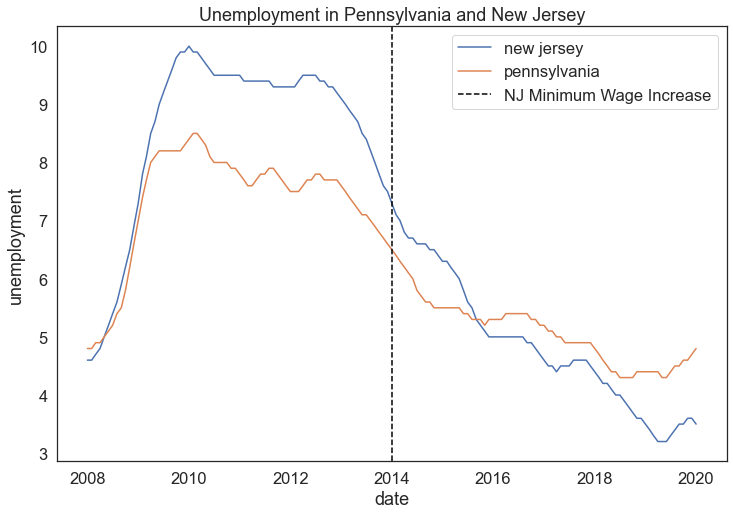

In [5]:
did=did[(did['date']>='2008-01-01') & (did['date']<='2020-01-01')]

sns.lineplot(data=did,x='date',y='unemployment',hue='state')
plt.axvline(pd.to_datetime('2014-01-01'),color='black',linestyle='dashed', label='NJ Minimum Wage Increase')
plt.title('Unemployment in Pennsylvania and New Jersey')
plt.legend()

This plot shows a big spike in unemployment occurring for both Pennsylvania and New Jersey as a result of the 2008 financial crisis. New jersey had a higher unemployment rate than Pennsylvania, but their trends are largely parallel and decreasing after 2012. In the years following the minimum wage law, New Jersey's unemployment rate actually dips below Pennsylvania's for the first time in years. Let's look at this in the form of boxplots:

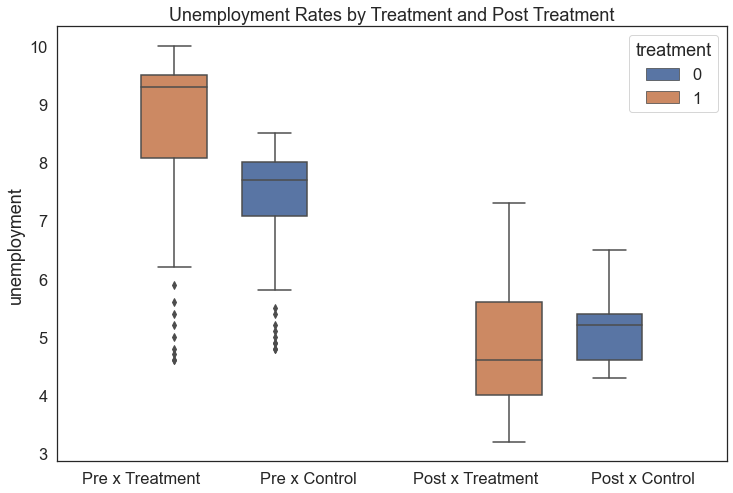

In [6]:
did['category']=did['treatment'].astype(str)+did['post'].astype(str) # this variable is just for the plot below
sns.boxplot(x='category', y='unemployment', hue='treatment', data=did).set_xticklabels(["Pre x Treatment", "Pre x Control",'Post x Treatment','Post x Control']) 
plt.xlabel('')
plt.title('Unemployment Rates by Treatment and Post Treatment')
plt.show()

This plot is fascinating in and of itself. The two box plots on the left show the unemployment values of the counties prior to the minimum wage law in 2014, while the two on the right show their values after the minimum wage increases.  Pennsylvania (the "control" group) is colored in blue, and New Jersey (the "treatment" group) is colored orange. Prior to the minimum wage increase in 2014, Pennsylvania (blue) has a lower unemployment rate than New Jersey (orange). In the years following New Jersey's passage of the minimum wage law, New Jersey actually has a *lower* unemployment rate than Pennsylvania! This is the only boxplot where the "treatment" (a minimum wage law) is being applied, and it has the lowest unemployment rate. 

Let's see if this difference is statistically signfiicant, and calculate a treatment effect: 

In [7]:
did_model = ols('unemployment ~ gdp+ post + treatment + post_treatment', did).fit()
print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:           unemployment   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     169.1
Date:                Thu, 02 Mar 2023   Prob (F-statistic):           5.70e-74
Time:                        11:59:41   Log-Likelihood:                -420.68
No. Observations:                 290   AIC:                             851.4
Df Residuals:                     285   BIC:                             869.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         15.6515      1.277     12.

There are some really interesting results from this model-- let's interpret the coefficients one by one.

* `gdp`: GDP is inversely related to unemployment. This makes sense: GDP basically measures the total amount of economic activity, so more economic activity = more employment. 
* `post`: this coefficient is negative, but statistically insignificant at the 0.05 level; it indicates that unemployment *generally* decreased for both groups, but that this could be due to random chance. 
* `treatment`: again negative but insignficant, meaning that there is no significant difference in unemployment levels between NJ and PA over the entire period. 
* `post_treatment`: this is our difference-in-differences estimator, and reflects the causal effect of treatment. It is negative and statistically significant. If we believe that the asusmptions of our model are satisfied, we can claim that:
    * **The introduction of a minimum wage in New Jersey led to a 1.95% decrease in unemployment relative to Pennsylvania**

This is a bold claim. We should do our best to back it up. Notice that i've sort of arbitrarily chosen a window of dates around the minimum wage law-- maybe this result is a fluke, due to the timespan ive chosen. 

To address this concern, I'll run the same model 10 times, starting with a really small time window-- just one year on either side of the law-- and progressively expand it.

In [8]:
models=[] # create empty list to store the models
names=[] # create empty list to store the names of the models

for window in range(1,10): # loop through years from 2000 to 2020 in increments of 4
    did=df_s[(df_s['date']>=str(2014-window)+'-01-01') & (df_s['date']<=str(2014+window)+'-01-01') & df_s['state'].isin(['pennsylvania', 'new jersey'])] # subset the data within the window of interest around 2014
    did['post']=np.where(did['date']>='2014-01-01',1,0) # create a dummy variable indicating the period after the minimum wage increase
    did['treatment']=np.where(did['state']=='new jersey',1,0) # create a dummy variable for treatment
    did['post_treatment']=did['post']*did['treatment'] # create an interaction term between the post and treatment variables
    did_model = ols('unemployment ~ gdp+ post + treatment + post_treatment', did).fit() # run the difference in difference model

    models.append(did_model) # append the model to the list of models
    names.append('± '+str(window)+' Year') # append the name of the model to the list of names

table=summary_col( # create a regression table 
    models, # pass the models to the summary_col function
    stars=True, # add stars denoting the p-values of the coefficient to the table; * p<0.05, ** p<0.01, *** p<0.001
    float_format='%0.3f', # set the decimal places to 3
    model_names=names, # set the names of the model
    info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))}) # add the number of observations to the table

print(table) # print the table



               ± 1 Year  ± 2 Year  ± 3 Year  ± 4 Year  ± 5 Year  ± 6 Year  ± 7 Year  ± 8 Year  ± 9 Year
-------------------------------------------------------------------------------------------------------
Intercept      21.423** 33.130*** 24.228*** 22.751*** 19.711*** 15.651*** 2.327     -0.580    -2.340*  
               (9.399)  (2.324)   (1.333)   (0.876)   (0.746)   (1.277)   (2.183)   (1.579)   (1.398)  
gdp            -0.000   -0.000*** -0.000*** -0.000*** -0.000*** -0.000*** 0.000**   0.000***  0.000*** 
               (0.000)  (0.000)   (0.000)   (0.000)   (0.000)   (0.000)   (0.000)   (0.000)   (0.000)  
post           -0.619   0.100     -0.262    -0.256*   -0.483*** -0.585*   -2.277*** -2.792*** -3.205***
               (0.411)  (0.194)   (0.162)   (0.140)   (0.154)   (0.307)   (0.576)   (0.501)   (0.479)  
treatment      -1.604   -3.686*** -1.850*** -1.466*** -0.903*** -0.364    1.825***  2.139***  2.241*** 
               (1.896)  (0.479)   (0.285)   (0.190)   (0.169)  

The row we're mainly interested in is the `post_treatment` coefficient, the treatment effect. It remains significant and negative in all time periods smaller than 8 years, after which point it becomes insignificant; 

How do you think this affects our conclusion?

## Exercise

Now we've got evidence that minimum wage laws may actually *decrease* unemployment in the case of New Jersey and Pennsylvania. But we've got quite a bit of data, and minimum wages change frequently. Explore the data to find a different pair of states with which to conduct a difference-in-differences analysis. Remember, we're looking for two states where

1. both had similar minimum wages, but one state increased their minimum wage while the other didn't 
2. both had parallel trends in terms of unemlpoyment prior to the minimium wage increase
3. ideally, the states will be geographically close together and have similar levels of GDP 

You can use the choropleth map below to search for such states by moving the date slider at the bottom, but you should also generate some plots of your own.

In [22]:
px.choropleth(df_s,
                locations='code', 
                scope='usa', 
                locationmode="USA-states",
                color="minwage", 
                animation_frame=df_s["year"].astype(str), 
                color_continuous_scale=px.colors.sequential.Viridis, 
                range_color=[7, 10], 
                height=500) 

In [21]:
df_s

,fips,state,year,month,population,unemployment,date,code,minwage,fedminwage,cpi,change,gdp
0,1,alabama,1976,1,2605000.0,6.6,1976-01-01,AL,0.00,10.0,56.9,0.00,NaN
1,2,alaska,1976,1,232000.0,7.1,1976-01-01,AK,12.73,10.0,56.9,2.63,NaN
2,4,arizona,1976,1,1621000.0,10.2,1976-01-01,AZ,0.00,10.0,56.9,-2.25,NaN
3,5,arkansas,1976,1,1536000.0,7.3,1976-01-01,AR,8.64,10.0,56.9,2.87,NaN
4,6,california,1976,1,15621000.0,9.2,1976-01-01,CA,9.09,10.0,56.9,1.16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29781,51,virginia,2022,10,6837076.0,2.7,2022-10-01,VA,NaN,NaN,NaN,NaN,NaN
29782,53,washington,2022,10,6210591.0,3.8,2022-10-01,WA,NaN,NaN,NaN,NaN,NaN
29783,54,west virginia,2022,10,1444427.0,4.0,2022-10-01,WV,NaN,NaN,NaN,NaN,NaN
29784,55,wisconsin,2022,10,4747412.0,3.3,2022-10-01,WI,NaN,NaN,NaN,NaN,NaN
